# IMDB positive / negative sentiment classification RNN

Two models of 3 layers were implemented to predict sentiment of movie reviews:
(!) Embedding - LSTM - Dense
(2) Embedding - Bidirectional LSTM - Dense

Both models have around 200k of trainable parameters, took about 560+ seconds per epoch to train, and attained lowest loss and highest test accuracy of around 87% within a few epochs. 
Model 2, the bidirectional model, however, was able to attain 87% accuracy earlier (at 3rd epoch) compared to the first (at 7th epoch)

Dataset:
25,000 train and 25,000 test movie reviews were downloaded from keras.datasets.
Reviews are of variable length of 7 to 2494 words.
Words are represented by single integer index.
There is a total of 5,967,841 words in all reviews, drawn from a vocabulary of 88,587


In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Dropout
from keras.layers import LSTM, Bidirectional
from keras.datasets import imdb


Using TensorFlow backend.


In [2]:
N_VOCAB = 10000
EMBED_DIM = 16
N_SEQ = 500



# Load and examine dataset

In [3]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=N_VOCAB)
print("------------------------------------------------------")
n_trn = x_train.shape[0]
n_tes = x_test.shape[0]
print(n_trn, 'train sequences with x, y types and shapes:', type(x_train), type(y_train), x_train.shape, y_train.shape)
print(n_tes, 'test sequences with x, y shapes:', type(x_test), type(y_test), x_test.shape, y_test.shape)


Loading data...
------------------------------------------------------
25000 train sequences with x, y types and shapes: <class 'numpy.ndarray'> <class 'numpy.ndarray'> (25000,) (25000,)
25000 test sequences with x, y shapes: <class 'numpy.ndarray'> <class 'numpy.ndarray'> (25000,) (25000,)


In [4]:
# print a random sample

import random

n = random.randint(0,n_trn)
print("One random sample of x and y :")
print("------------------------------------------------------")
print("x type and len:", type(x_train[n]),len(x_train[n]))
print("y type and shape:", type(y_train[n]), y_train[n].shape)

print("------------------------------------------------------")
print("x_train[",n,"]", x_train[n])
print("y_train[",n,"]", y_train[n])
print("------------------------------------------------------")



One random sample of x and y :
------------------------------------------------------
x type and len: <class 'list'> 293
y type and shape: <class 'numpy.int64'> ()
------------------------------------------------------
x_train[ 17466 ] [1, 723, 1655, 848, 9, 35, 2, 37, 43, 571, 8, 30, 3953, 8, 6, 552, 6, 2549, 773, 4115, 2, 2983, 59, 4880, 27, 1649, 5, 27, 2933, 7262, 33, 27, 6282, 1073, 723, 214, 6, 117, 99, 1819, 5, 820, 630, 56, 656, 6, 184, 3189, 773, 2, 2686, 7636, 145, 8, 27, 2, 164, 575, 17, 36, 135, 21, 4, 3893, 81, 3290, 56, 11, 4, 172, 1445, 1087, 4115, 2, 442, 23, 41, 96, 8, 9981, 1603, 7732, 723, 2, 2, 46, 7, 4, 273, 261, 41, 2, 26, 317, 496, 21, 50, 9, 60, 53, 253, 1404, 33, 6, 223, 3068, 33, 2, 9261, 344, 723, 1129, 2, 83, 2, 174, 2799, 15, 59, 9, 2, 3242, 740, 44, 49, 4121, 8, 81, 21, 305, 723, 4880, 8, 2, 6, 2879, 439, 5, 5932, 46, 11, 4, 3868, 80, 4115, 126, 169, 46, 15, 2, 1084, 4, 314, 33, 9981, 273, 5, 51, 80, 30, 4, 3615, 146, 806, 18, 1418, 37, 4381, 102, 40, 14, 

Min and max doc length : 7 2494


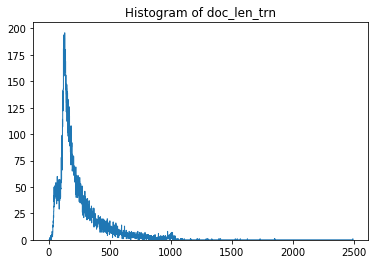

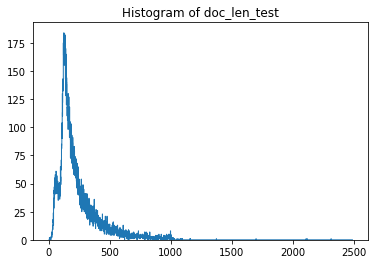

In [5]:
# x_train is numpy array of lists of variable number of integers representing words
# find number of words in longest and shortest article

doc_len = lambda i : len(x_train[i])
min_doc_len = min(min(len(x_train[i]) for i in range(n_trn)), min(len(x_test[j]) for j in range(n_tes)))
max_doc_len = max(max(len(x_train[i]) for i in range(n_trn)), max(len(x_test[j]) for j in range(n_tes)))
doc_len_trn = list(len(x_train[i]) for i in range(n_trn)) 
doc_len_tes = list(len(x_test[i]) for i in range(n_tes))

print("Min and max doc length :", min_doc_len, max_doc_len)

hist_cumulative = False
if hist_cumulative:
    s = "Cumulative histogram"
else:
    s = "Histogram"
plt.hist(doc_len_trn, bins=max_doc_len, range=[0, max_doc_len], cumulative=hist_cumulative, histtype='step')
plt.title(s + " of doc_len_trn")
plt.show()
plt.hist(doc_len_tes, bins=max_doc_len, range=[0, max_doc_len], cumulative=hist_cumulative,histtype='step')
plt.title(s + " of doc_len_test")
plt.show()

Total number of words: 5967841
Vocab range: 1 9999


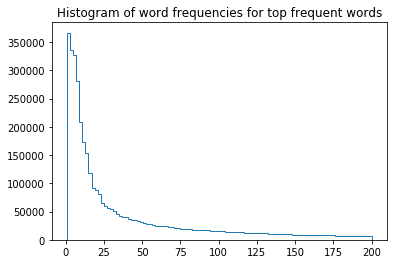

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
words_all = flatten(x_train)

print("Total number of words:",len(words_all))
print("Vocab range:", min(words_all), max(words_all))
n_vocab = max(words_all)

#plt.hist(words_all, bins=max(words_all), range=[min(words_all), max(words_all)], histtype='step')
plt.hist(words_all, bins=100, range=[min(words_all), 200], cumulative=False, histtype='step')
plt.title("Histogram of word frequencies for top frequent words")
plt.show()


Number of words: 
9998
Review length: 
Mean 234.76 words (172.911495)


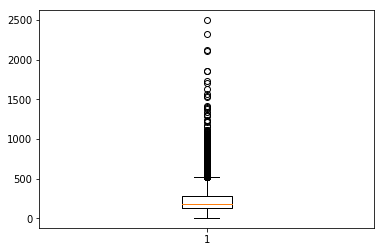

In [7]:
# alternative to checking vocab range and review length

X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Summarize number of words  --- this is capped by max_features variable above
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()


min and max value in y: 0 1


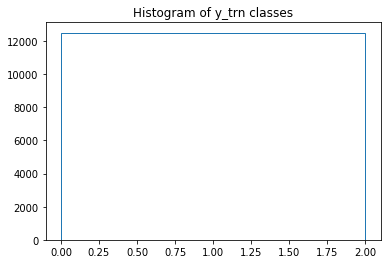

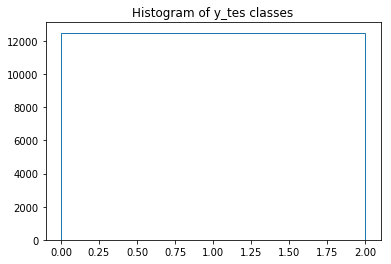

In [8]:
# check y classess and histogram
import numpy as np

n_classes = np.max(y_train)+1
print("min and max value in y:", np.min(y_train), n_classes-1)

plt.hist(y_train, bins=n_classes, range=[0, n_classes], histtype='step')
plt.title("Histogram of y_trn classes")
plt.show()


plt.hist(y_test, bins=n_classes, range=[0, n_classes], histtype='step')
plt.title("Histogram of y_tes classes")
plt.show()

# Format data for training


In [9]:
seqlen = 80    # cut texts after this number of words

print('Pad sequences (samples x time)')
x_train_pad = sequence.pad_sequences(x_train, maxlen=N_SEQ)
x_test_pad = sequence.pad_sequences(x_test, maxlen=N_SEQ)

# reshape X to be [samples, time steps, features]
#x_train_reshaped = np.reshape(x_train_pad, (x_train_pad.shape[0], N_SEQ, 1))
#x_test_reshaped = np.reshape(x_test_pad, (x_test_pad.shape[0], N_SEQ, 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

#split val and test set
n = x_test_pad.shape[0]
vsplit = int(0.75*n)
x_val_pad = x_test_pad[0:vsplit,:]
x_test_pad = x_test_pad[vsplit:,:]
y_val = y_test[0:vsplit,:]
y_test = y_test[vsplit:,:]

print('x_train, x_test :', x_train.shape, x_test.shape)
print('x_train_pad, x_val_pad, x_test_pad:', x_train_pad.shape, x_val_pad.shape, x_test_pad.shape)
print('y_train, y_val, y_test:', y_train.shape, y_val.shape, y_test.shape)


Pad sequences (samples x time)
x_train, x_test : (25000,) (25000,)
x_train_pad, x_val_pad, x_test_pad: (25000, 500) (18750, 500) (6250, 500)
y_train, y_val, y_test: (25000, 1) (18750, 1) (6250, 1)


# Build model and run

In [10]:
# Model1: Embedding-LSTM-Dense 

inp1 = Input(shape=(N_SEQ,),name='Input')                                              # ?, N_SEQ
x1 = Embedding(N_VOCAB, EMBED_DIM, input_length=N_SEQ,name='Embedding')(inp1)          # ?, N_SEQ, EMBED_DIM
x1 = LSTM(100, name="LSTM")(x1)                                                        # ?, 100
x1 = Dropout(0.2, name="Dropout1")(x1)                                                 # ?, 100
output1 = Dense(1, activation ='sigmoid', name='Output')(x1)                           # ?, 1

model1 = Model(inputs = inp1, outputs=output1)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 500)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               46800     
_________________________________________________________________
Dropout1 (Dropout)           (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 206,901
Trainable params: 206,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model2: Embedding-BidirectionalLSTM-Dense 

inp2 = Input(shape=(N_SEQ,),name='Input')                                              # ?, N_SEQ
x2 = Embedding(N_VOCAB, EMBED_DIM, input_length=N_SEQ,name='Embedding')(inp2)          # ?, N_SEQ, EMBED_DIM
x2 = Bidirectional(LSTM(64),name="BiLSTM")(x2)                                         # ?, 2x64
x2 = Dropout(0.2, name="Dropout1")(x2)                                                 # ?, 2x64
output2 = Dense(1, activation ='sigmoid', name='Output')(x2)                           # ?, 1

model2 = Model(inputs = inp2, outputs=output2)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 500)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 128)               41472     
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 129       
Total params: 201,601
Trainable params: 201,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
def plot_train(hist, meas):
    h = hist.history
    if meas == 'acc':
        loc='lower right'
    else:
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    plt.show()

def train_model(model_num, batch_size=32, epochs=10):
    if model_num == 1:
        model = model1
        s = '1'
        print('Training model1 ...')
    else:
        model = model2
        s = '2'
        print('Training model2 ...')
    print("Model summary:")
    print(model.summary())
    print('')

    hist = model.fit(x_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val_pad, y_val))
    loss, acc = model.evaluate(x_test_pad, y_test, batch_size=batch_size)

    print('')
    print('Test loss:', loss)
    print('Test accuracy:', acc)

    fname = './models/RNN_imdb_' + s + '.h5'
    print('Saved model to:',fname)
    model.save(fname)
    
    print('Plot train history . . .')
    plot_train(hist, 'loss')
    plot_train(hist, 'acc')
    print('Model'+ s +' training done!')


Training model1 ...
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 500)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               46800     
_________________________________________________________________
Dropout1 (Dropout)           (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 206,901
Trainable params: 206,901
Non-trainable params: 0
_________________________________________________________________
None

Train on 25000 samples, validate on 18750 samples
Epoch 1/10
25000/25000 [=====================

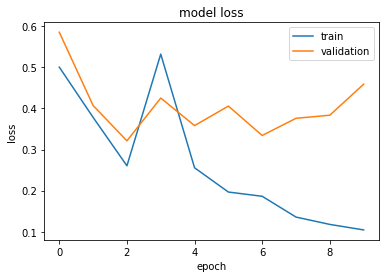

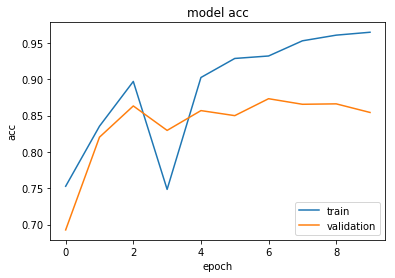

Model1 training done!


In [13]:
train_model(1, batch_size=32, epochs=10)

Training model2 ...
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 500)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 128)               41472     
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 129       
Total params: 201,601
Trainable params: 201,601
Non-trainable params: 0
_________________________________________________________________
None

Train on 25000 samples, validate on 18750 samples
Epoch 1/10
25000/25000 [=====================

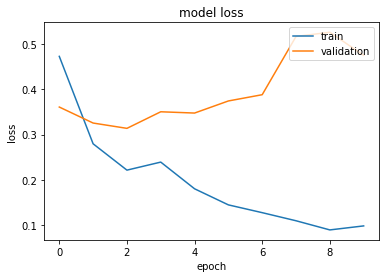

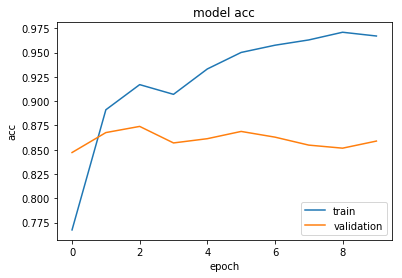

Model2 training done!


In [14]:
train_model(2, batch_size=32, epochs=10)

# Copy of results of training for 2 models

# Results of model 1, Embedding - LSTM - Dense


    Training model1 ...
    Model summary:
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    Input (InputLayer)           (None, 500)               0         
    _________________________________________________________________
    Embedding (Embedding)        (None, 500, 16)           160000    
    _________________________________________________________________
    LSTM (LSTM)                  (None, 100)               46800     
    _________________________________________________________________
    Dropout1 (Dropout)           (None, 100)               0         
    _________________________________________________________________
    Output (Dense)               (None, 1)                 101       
    =================================================================
    Total params: 206,901
    Trainable params: 206,901
    Non-trainable params: 0
    _________________________________________________________________
    None

    Train on 25000 samples, validate on 18750 samples
    Epoch 1/10
    25000/25000 [==============================] - 559s - loss: 0.5005 - acc: 0.7528 - val_loss: 0.5853 - val_acc: 0.6927
    Epoch 2/10
    25000/25000 [==============================] - 564s - loss: 0.3782 - acc: 0.8355 - val_loss: 0.4071 - val_acc: 0.8204
    Epoch 3/10
    25000/25000 [==============================] - 578s - loss: 0.2604 - acc: 0.8971 - val_loss: 0.3212 - val_acc: 0.8634
    Epoch 4/10
    25000/25000 [==============================] - 577s - loss: 0.5321 - acc: 0.7485 - val_loss: 0.4252 - val_acc: 0.8297
    Epoch 5/10
    25000/25000 [==============================] - 563s - loss: 0.2556 - acc: 0.9025 - val_loss: 0.3582 - val_acc: 0.8570
    Epoch 6/10
    25000/25000 [==============================] - 562s - loss: 0.1966 - acc: 0.9287 - val_loss: 0.4057 - val_acc: 0.8500
    
    Epoch 7/10
    25000/25000 [==============================] - 563s - loss: 0.1862 - acc: 0.9321 - val_loss: 0.3342 - val_acc: 0.8733
    
    Epoch 8/10
    25000/25000 [==============================] - 563s - loss: 0.1357 - acc: 0.9530 - val_loss: 0.3760 - val_acc: 0.8657
    Epoch 9/10
    25000/25000 [==============================] - 563s - loss: 0.1178 - acc: 0.9608 - val_loss: 0.3835 - val_acc: 0.8662
    Epoch 10/10
    25000/25000 [==============================] - 563s - loss: 0.1044 - acc: 0.9648 - val_loss: 0.4589 - val_acc: 0.8544
    6250/6250 [==============================] - 33s    

    Test loss: 0.475474571857
    Test accuracy: 0.850719999981
    Saved model to: ./models/RNN_imdb_1.h5
    Plot train history . . .

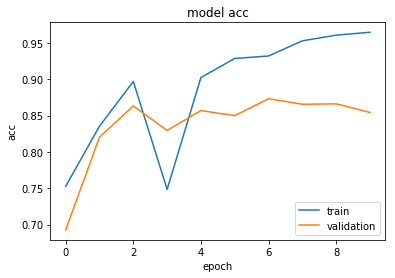

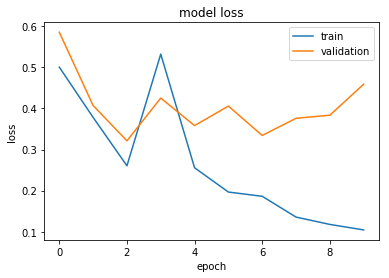

# Results of model 2, Embedding - Bidirectional LSTM - Dense

    Training model2 ...
    Model summary:
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    Input (InputLayer)           (None, 500)               0         
    _________________________________________________________________
    Embedding (Embedding)        (None, 500, 16)           160000    
    _________________________________________________________________
    BiLSTM (Bidirectional)       (None, 128)               41472     
    _________________________________________________________________
    Dropout1 (Dropout)           (None, 128)               0         
    _________________________________________________________________
    Output (Dense)               (None, 1)                 129       
    =================================================================
    Total params: 201,601
    Trainable params: 201,601
    Non-trainable params: 0
    _________________________________________________________________
    None

    Train on 25000 samples, validate on 18750 samples
    Epoch 1/10
    25000/25000 [==============================] - 724s - loss: 0.4731 - acc: 0.7675 - val_loss: 0.3610 - val_acc: 0.8471
    Epoch 2/10
    25000/25000 [==============================] - 734s - loss: 0.2797 - acc: 0.8912 - val_loss: 0.3256 - val_acc: 0.8677

    Epoch 3/10  
    25000/25000 [==============================] - 731s - loss: 0.2214 - acc: 0.9170 - val_loss: 0.3138 - val_acc: 0.8740

    Epoch 4/10
    25000/25000 [==============================] - 726s - loss: 0.2392 - acc: 0.9070 - val_loss: 0.3505 - val_acc: 0.8570
    Epoch 5/10
    25000/25000 [==============================] - 725s - loss: 0.1801 - acc: 0.9332 - val_loss: 0.3477 - val_acc: 0.8614
    Epoch 6/10
    25000/25000 [==============================] - 724s - loss: 0.1445 - acc: 0.9502 - val_loss: 0.3744 - val_acc: 0.8689
    Epoch 7/10
    25000/25000 [==============================] - 725s - loss: 0.1273 - acc: 0.9576 - val_loss: 0.3883 - val_acc: 0.8630
    Epoch 8/10
    25000/25000 [==============================] - 726s - loss: 0.1094 - acc: 0.9630 - val_loss: 0.5171 - val_acc: 0.8548
    Epoch 9/10
    25000/25000 [==============================] - 726s - loss: 0.0891 - acc: 0.9710 - val_loss: 0.5265 - val_acc: 0.8516
    Epoch 10/10
    25000/25000 [==============================] - 729s - loss: 0.0980 - acc: 0.9671 - val_loss: 0.4753 - val_acc: 0.8589
    6250/6250 [==============================] - 41s    

    Test loss: 0.49817690094
    Test accuracy: 0.854879999962
    Saved model to: ./models/RNN_imdb_2.h5
    Plot train history . . .

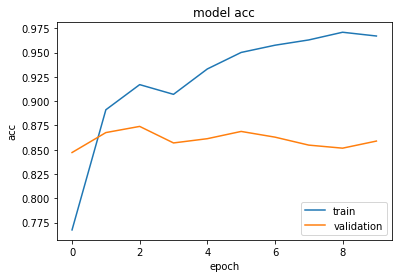



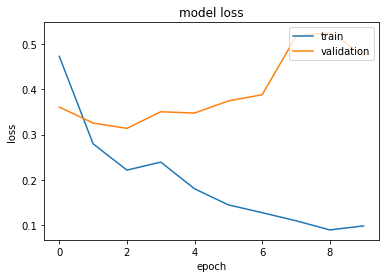